<a href="https://colab.research.google.com/github/Ryan0v0/nninn/blob/master/vq_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip3 install -U -r requirements.txt

# Step1: Splitting up neural net params into chunks

In [ ]:
import torch
import torch.nn as nn

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(10, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

        # Initialize the weights to be non-negative
        nn.init.uniform_(self.fc1.weight, a=0, b=1)
        nn.init.uniform_(self.fc2.weight, a=0, b=1)
        nn.init.uniform_(self.fc3.weight, a=0, b=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the neural network
net = NeuralNetwork()

# Split up the neural network parameters into chunks
chunk_size = 1000
param_chunks = []
for param in net.parameters():
    flattened_param = param.view(-1)
    chunks = torch.split(flattened_param, chunk_size)
    param_chunks.extend(chunks)

# Print the number of parameter chunks
print("Number of parameter chunks:", len(param_chunks))
print("Parameter chunks:", param_chunks)


Number of parameter chunks: 15
Parameter chunks: [tensor([7.1851e-01, 6.2237e-01, 6.9191e-01, 2.4712e-02, 5.0765e-01, 4.4440e-01,
        2.1151e-01, 2.2879e-01, 3.0134e-01, 2.5301e-01, 5.6201e-01, 6.9394e-01,
        9.9110e-01, 8.7780e-01, 9.8581e-01, 3.4031e-01, 1.9593e-01, 7.3739e-01,
        6.1132e-01, 2.4401e-01, 5.3588e-01, 4.8000e-01, 3.4889e-01, 3.0824e-02,
        8.9073e-01, 7.3190e-01, 2.0004e-01, 7.9498e-01, 8.4673e-01, 4.3924e-02,
        6.5294e-01, 1.5892e-01, 6.8574e-01, 1.7451e-01, 3.5812e-01, 8.5558e-01,
        7.7970e-01, 5.2774e-01, 9.2514e-01, 3.0153e-01, 3.6376e-01, 7.7111e-01,
        1.6636e-01, 9.1859e-01, 5.0898e-01, 6.4640e-01, 5.5042e-02, 1.6410e-02,
        3.8419e-01, 3.9570e-01, 4.6773e-01, 7.2047e-01, 7.9951e-01, 9.2785e-01,
        1.8951e-02, 6.7706e-02, 1.1297e-01, 8.3276e-01, 5.4782e-01, 9.1999e-01,
        4.7233e-01, 1.8927e-01, 4.1096e-01, 8.5869e-01, 6.9278e-01, 4.7377e-01,
        3.8494e-01, 4.9596e-01, 6.9117e-01, 4.9564e-01, 2.0846e-01, 4.

In [ ]:
import numpy as np

# Convert param_chunks to a numpy array
param_chunks_np = np.concatenate([chunk.detach().numpy() for chunk in param_chunks])

print(type(param_chunks_np))
print("size:", param_chunks_np.shape)

<class 'numpy.ndarray'>
size: (11301,)


# Step2: learning a mapping from each chunk to an integer via VQ-VAE

In [ ]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

# import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

using the weights of the above neural network as input.

In [ ]:
data_variance = np.var(param_chunks_np / 255.0)

print(data_variance)

1.3355306e-06


## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        '''
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        '''
        # convert inputs from HW -> HW
        inputs = inputs.permute(0, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 1).contiguous(), perplexity, encodings # (0, 3, 1, 2)

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [ ]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 1).contiguous() # (0, 2, 3, 1)
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 1).contiguous(), perplexity, encodings # (0, 3, 1, 2)

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [ ]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv1d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv1d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._linear_1 = nn.Linear(in_channels*64, num_hiddens//2)
        self._linear_2 = nn.Linear(num_hiddens//2, num_hiddens)

        '''
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        '''

    def forward(self, inputs):
        x = self._linear_1(inputs.view(inputs.size(0), -1)) # x = self._linear_1(inputs)
        x = F.relu(x)

        x = self._linear_2(x)
        x = F.relu(x)

        return x # self._residual_stack(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._linear_1 = nn.Linear(in_channels, num_hiddens)
        '''
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        '''
        self._linear_2 = nn.Linear(num_hiddens, num_hiddens//2)

    def forward(self, inputs):
        x = self._linear_1(inputs.view(inputs.size(0), -1)) # x = self._linear_1(inputs)

        # x = self._residual_stack(x)

        x = self._linear_2(x)
        x = F.relu(x)

        return x

## Train

We use the hyperparameters from the author's code:

In [ ]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Create a TensorDataset from param_chunks_np
dataset = TensorDataset(torch.from_numpy(param_chunks_np))

# Set the batch size and other DataLoader parameters
batch_size = 64
shuffle = True
pin_memory = True

# Create the DataLoader using the custom dataset
training_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)

print(training_loader)

print(iter(training_loader))

data = next(iter(training_loader))

print("ori_data=", data)

print(type(next(iter(training_loader))))
# print(data[0])

data = next(iter(training_loader))
# for i in range(len(data)):
#    data[i] = data[i].to(device)
data = torch.stack(data).to(device)
print("data=", data)

# There's no label in the NN weight dataset
'''
for batch_idx, data in enumerate(training_loader):
    print("Batch Index:", batch_idx)
    print("Data:", data)
    print()
'''

ori_data= [tensor([0.9987, 0.0837, 0.8892, 0.9612, 0.5779, 0.5428, 0.8213, 0.5816, 0.4451,
        0.6820, 0.3003, 0.6115, 0.4024, 0.0519, 0.8102, 0.4817, 0.1380, 0.8465,
        0.4678, 0.8126, 0.8453, 0.7748, 0.4584, 0.0297, 0.3307, 0.8973, 0.5007,
        0.7179, 0.9101, 0.5906, 0.9124, 0.2726, 0.3281, 0.6734, 0.8778, 0.9616,
        0.2192, 0.8790, 0.5764, 0.3547, 0.8626, 0.1425, 0.1769, 0.0489, 0.7946,
        0.2609, 0.7134, 0.1685, 0.2359, 0.0733, 0.8441, 0.2988, 0.2073, 0.6296,
        0.0879, 0.7292, 0.9173, 0.2195, 0.7781, 0.5295, 0.2066, 0.8683, 0.1681,
        0.8702])]
<class 'list'>
data= tensor([[ 0.3653,  0.8310,  0.6386,  0.7896,  0.6743,  0.0742,  0.3951,  0.3101,
          0.7066,  0.8433,  0.5777,  0.1289,  0.5197,  0.9888,  0.1075,  0.0138,
          0.7749,  0.3798,  0.7840,  0.8762,  0.2247,  0.4057,  0.6874,  0.0893,
          0.1996,  0.1330,  0.0044,  0.3746,  0.8993,  0.0046,  0.6925,  0.4251,
          0.3979,  0.0614,  0.2374,  0.4627,  0.2866,  0.3820,  0.

'\nfor batch_idx, data in enumerate(training_loader):\n    print("Batch Index:", batch_idx)\n    print("Data:", data)\n    print()\n'

In [ ]:
cifar_training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

cifar_training_loader = DataLoader(cifar_training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

print(cifar_training_loader)

print(iter(cifar_training_loader))

(data, _) = next(iter(cifar_training_loader))
print(type(next(iter(cifar_training_loader))))
print(type(data))
print(type(_))
print("ori_data=", data)

data = data.to(device)

print("data=", data)

'''
for batch_idx, (data, _) in enumerate(cifar_training_loader):
    print("Batch Index:", batch_idx)
    # print("Data:", data)
    print("Label:", _)
    print()
'''

Files already downloaded and verified
<class 'list'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
ori_data= tensor([[[[-0.1196, -0.1118, -0.1157,  ..., -0.1039, -0.0843, -0.0843],
          [ 0.0294,  0.0176,  0.0176,  ..., -0.0804, -0.0647, -0.0882],
          [ 0.0647,  0.0490,  0.0451,  ..., -0.0843, -0.0882, -0.1039],
          ...,
          [-0.1627, -0.1706, -0.1706,  ..., -0.2137, -0.2373, -0.2804],
          [-0.1980, -0.2020, -0.2059,  ..., -0.3039, -0.3235, -0.3510],
          [-0.2373, -0.2451, -0.2451,  ..., -0.3863, -0.3824, -0.3863]],

         [[-0.0765, -0.0765, -0.0804,  ..., -0.1039, -0.0843, -0.0804],
          [ 0.1392,  0.1314,  0.1392,  ..., -0.0647, -0.0451, -0.0647],
          [ 0.2333,  0.2216,  0.2255,  ..., -0.0843, -0.0882, -0.1000],
          ...,
          [-0.2333, -0.2412, -0.2412,  ..., -0.2608, -0.2843, -0.3275],
          [-0.2686, -0.2725, -0.2765,  ..., -0.3392, -0.3549, -0.3824],
          [-0.3039, -0.3078, -0.3118,  ..., -0.4098, -0.4059, -0.40

'\nfor batch_idx, (data, _) in enumerate(cifar_training_loader):\n    print("Batch Index:", batch_idx)\n    # print("Data:", data)\n    print("Label:", _)\n    print()\n'

In [ ]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        # Updated input size to [1, 64]
        self._encoder = Encoder(1, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

        # Replaced with nn.Linear
        self._pre_vq_linear = nn.Linear(num_hiddens, embedding_dim)

        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)

        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)


    def forward(self, x):
        # x = x.unsqueeze(0)  # Add an extra dimension for batch size
        ## print("x=", x)
        ## print(x.shape)
        z = self._encoder(x)
        z = z.view(z.size(0), -1)  # Flatten the tensor
        ## print("z0=", z)
        # Replaced self._pre_vq_conv with self._pre_vq_linear
        z = self._pre_vq_linear(z)
        ## print("z1=", z)

        loss, quantized, perplexity, _ = self._vq_vae(z)
        ## print("quantized:", quantized)

        # # Reshape quantized before passing it to the decoder
        # quantized = quantized.unsqueeze(2).unsqueeze(3)
        # print("quantized_after:", quantized)
        x_recon = self._decoder(quantized)

        # x_recon = 0
        return loss, x_recon, perplexity

In [ ]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [ ]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in xrange(num_training_updates):
    # (data, _) = next(iter(training_loader))
    # data = data.to(device)
    data = next(iter(training_loader))
    data = torch.stack(data).to(device)
    #for i in range(len(data)):
    #  data[i] = data[i].to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        % print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

100 iterations
recon_error: 6457055.848
perplexity: 1.000

200 iterations
recon_error: 192350.233
perplexity: 1.000

300 iterations
recon_error: 146587.510
perplexity: 1.000

400 iterations
recon_error: 121408.033
perplexity: 1.000

500 iterations
recon_error: 101813.981
perplexity: 1.000

600 iterations
recon_error: 93564.669
perplexity: 1.000

700 iterations
recon_error: 92244.182
perplexity: 1.000

800 iterations
recon_error: 89081.391
perplexity: 1.000

900 iterations
recon_error: 94212.106
perplexity: 1.000

1000 iterations
recon_error: 95659.677
perplexity: 1.000

1100 iterations
recon_error: 94446.051
perplexity: 1.000

1200 iterations
recon_error: 95878.895
perplexity: 1.000

1300 iterations
recon_error: 95851.265
perplexity: 1.000

1400 iterations
recon_error: 90210.002
perplexity: 1.000

1500 iterations
recon_error: 89792.214
perplexity: 1.000

1600 iterations
recon_error: 97843.034
perplexity: 1.000

1700 iterations
recon_error: 85901.337
perplexity: 1.000

1800 iterations
r


*The reason of the error:*

When using the ReLU activation function, if the input of a neuron is negative, it causes the neuron to output zero constantly, resulting in deactivation. Since the gradient is zero at this point, it cannot recover.



## Plot Loss

In [ ]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

"\nax = f.add_subplot(1,2,2)\nax.plot(train_res_perplexity_smooth)\nax.set_title('Smoothed Average codebook usage (perplexity).')\nax.set_xlabel('iteration')\n"

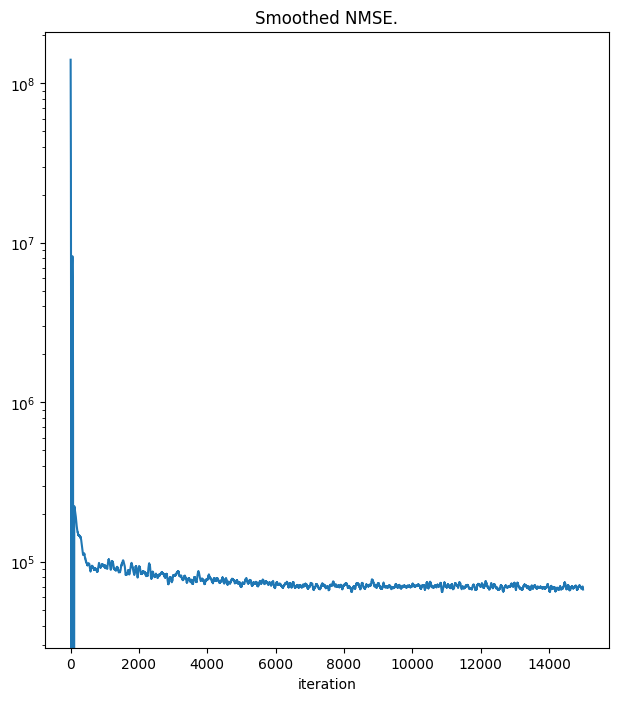

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)

ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')
'''
ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')
'''

## View Reconstructions

In [ ]:
model.eval()

data = next(iter(training_loader))
train_originals = torch.stack(data).to(device)
vq_output_eval = model._pre_vq_linear(model._encoder(train_originals))
print("vq_output_eval=", vq_output_eval)
print("vq_output_eval.shape=", vq_output_eval.shape)
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
print(valid_quantize)
print("valid_quantize=", valid_quantize)
print("valid_quantize.shape=", valid_quantize.shape)
# (train_originals, _) = next(iter(training_loader))
# train_originals = train_originals.to(device)
valid_reconstructions = model._decoder(valid_quantize)

vq_output_eval= tensor([[ 4.2000e+00,  3.4573e-01, -6.0922e-03,  4.9490e+00,  5.8922e+00,
         -3.4437e+00, -4.6094e+00,  3.3776e+00, -2.6236e+00, -4.9217e+00,
          3.7969e+00,  1.7772e+00,  4.1331e+00,  5.3000e+00,  4.5955e+00,
          1.4478e+00, -1.7131e-01, -3.7096e+00, -2.9014e+00, -6.2335e+00,
         -9.5910e+00,  6.6834e+00,  2.3847e+00,  2.9382e+00, -2.6834e+00,
          5.3260e-02,  1.3684e+00, -4.0423e+00,  1.0650e+00, -6.5871e+00,
         -2.0515e+00,  2.5385e+00, -1.0978e+00,  5.2365e+00,  4.2382e+00,
          2.3444e+00, -1.2222e+00, -1.8329e+00, -3.4228e+00, -3.7165e+00,
         -1.3708e+00, -4.7944e+00, -9.4455e-01,  3.5895e+00,  9.3222e-01,
         -1.0197e+00,  9.4478e-01,  2.8057e+00,  2.4831e+00, -8.2739e-01,
          1.0693e+00, -3.8591e+00,  2.5269e+00,  1.6218e+00,  4.7415e+00,
          2.3302e+00, -4.7821e+00,  4.8902e+00, -2.2899e-01, -2.6762e+00,
         -2.1920e-01, -1.8884e+00,  4.0961e+00,  9.6069e+00]],
       grad_fn=<AddmmBackward0>)


In [ ]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [ ]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

In [ ]:
show(make_grid(train_originals.cpu()+0.5))

## View Embedding

In [ ]:
! pip uninstall umap
! pip install umap-learn

import umap.umap_ as umap

proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=29e94e255f4601a597809a1cb7e766de5f620d4706d405df062173e663dda1d0
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=4e7ff888694b1e0899dcc8a97b676d90cffaec2c31e37411b25d52953099cf2a
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


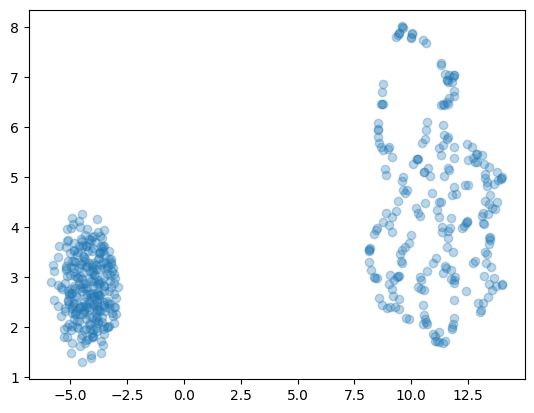

In [ ]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

# JAX version

In [ ]:
"""Haiku implementation of VQ-VAE https://arxiv.org/abs/1711.00937."""

from typing import Any, Optional

from haiku._src import base
from haiku._src import initializers
from haiku._src import module
from haiku._src import moving_averages

import jax
import jax.numpy as jnp


# If you are forking replace this with `import haiku as hk`.
# pylint: disable=invalid-name
class hk:
  get_parameter = base.get_parameter
  get_state = base.get_state
  set_state = base.set_state
  initializers = initializers
  ExponentialMovingAverage = moving_averages.ExponentialMovingAverage
  Module = module.Module
# pylint: enable=invalid-name
del base, initializers, module, moving_averages


class VectorQuantizer(hk.Module):
  """Haiku module representing the VQ-VAE layer.

  Implements the algorithm presented in
  "Neural Discrete Representation Learning" by van den Oord et al.
  https://arxiv.org/abs/1711.00937

  Input any tensor to be quantized. Last dimension will be used as space in
  which to quantize. All other dimensions will be flattened and will be seen
  as different examples to quantize.

  The output tensor will have the same shape as the input.

  For example a tensor with shape ``[16, 32, 32, 64]`` will be reshaped into
  ``[16384, 64]`` and all ``16384`` vectors (each of ``64`` dimensions)  will be
  quantized independently.

  Attributes:
    embedding_dim: integer representing the dimensionality of the tensors in the
      quantized space. Inputs to the modules must be in this format as well.
    num_embeddings: integer, the number of vectors in the quantized space.
    commitment_cost: scalar which controls the weighting of the loss terms (see
      equation 4 in the paper - this variable is Beta).
  """

  def __init__(
      self,
      embedding_dim: int,
      num_embeddings: int,
      commitment_cost: float,
      dtype: Any = jnp.float32,
      name: Optional[str] = None,
      cross_replica_axis: Optional[str] = None,
  ):
    """Initializes a VQ-VAE module.

    Args:
      embedding_dim: dimensionality of the tensors in the quantized space.
        Inputs to the modules must be in this format as well.
      num_embeddings: number of vectors in the quantized space.
      commitment_cost: scalar which controls the weighting of the loss terms
        (see equation 4 in the paper - this variable is Beta).
      dtype: dtype for the embeddings variable, defaults to ``float32``.
      name: name of the module.
      cross_replica_axis: If not ``None``, it should be a string representing
        the axis name over which this module is being run within a
        :func:`jax.pmap`. Supplying this argument means that perplexity is
        calculated across all replicas on that axis.
    """
    super().__init__(name=name)
    self.embedding_dim = embedding_dim
    self.num_embeddings = num_embeddings
    self.commitment_cost = commitment_cost
    self.cross_replica_axis = cross_replica_axis

    self._embedding_shape = [embedding_dim, num_embeddings]
    self._embedding_dtype = dtype

  @property
  def embeddings(self):
    initializer = hk.initializers.VarianceScaling(distribution="uniform")
    return hk.get_parameter(
        "embeddings",
        self._embedding_shape,
        self._embedding_dtype,
        init=initializer)

  def __call__(self, inputs, is_training):
    """Connects the module to some inputs.

    Args:
      inputs: Tensor, final dimension must be equal to ``embedding_dim``. All
        other leading dimensions will be flattened and treated as a large batch.
      is_training: boolean, whether this connection is to training data.

    Returns:
      dict: Dictionary containing the following keys and values:
        * ``quantize``: Tensor containing the quantized version of the input.
        * ``loss``: Tensor containing the loss to optimize.
        * ``perplexity``: Tensor containing the perplexity of the encodings.
        * ``encodings``: Tensor containing the discrete encodings, ie which
          element of the quantized space each input element was mapped to.
        * ``encoding_indices``: Tensor containing the discrete encoding indices,
          ie which element of the quantized space each input element was mapped
          to.
    """
    flat_inputs = jnp.reshape(inputs, [-1, self.embedding_dim])

    distances = (
        jnp.sum(jnp.square(flat_inputs), 1, keepdims=True) -
        2 * jnp.matmul(flat_inputs, self.embeddings) +
        jnp.sum(jnp.square(self.embeddings), 0, keepdims=True))

    encoding_indices = jnp.argmax(-distances, 1)
    encodings = jax.nn.one_hot(encoding_indices,
                               self.num_embeddings,
                               dtype=distances.dtype)

    # NB: if your code crashes with a reshape error on the line below about a
    # Tensor containing the wrong number of values, then the most likely cause
    # is that the input passed in does not have a final dimension equal to
    # self.embedding_dim. Ideally we would catch this with an Assert but that
    # creates various other problems related to device placement / TPUs.
    encoding_indices = jnp.reshape(encoding_indices, inputs.shape[:-1])
    quantized = self.quantize(encoding_indices)

    e_latent_loss = jnp.mean(
        jnp.square(jax.lax.stop_gradient(quantized) - inputs))
    q_latent_loss = jnp.mean(
        jnp.square(quantized - jax.lax.stop_gradient(inputs)))
    loss = q_latent_loss + self.commitment_cost * e_latent_loss

    # Straight Through Estimator
    quantized = inputs + jax.lax.stop_gradient(quantized - inputs)
    avg_probs = jnp.mean(encodings, 0)
    if self.cross_replica_axis:
      avg_probs = jax.lax.pmean(avg_probs, axis_name=self.cross_replica_axis)
    perplexity = jnp.exp(-jnp.sum(avg_probs * jnp.log(avg_probs + 1e-10)))

    return {
        "quantize": quantized,
        "loss": loss,
        "perplexity": perplexity,
        "encodings": encodings,
        "encoding_indices": encoding_indices,
        "distances": distances,
    }

  def quantize(self, encoding_indices):
    """Returns embedding tensor for a batch of indices."""
    w = self.embeddings.swapaxes(1, 0)
    w = jax.device_put(w)  # Required when embeddings is a NumPy array.
    return w[(encoding_indices,)]


class VectorQuantizerEMA(hk.Module):
  r"""Haiku module representing the VQ-VAE layer.

  Implements a slightly modified version of the algorithm presented in
  "Neural Discrete Representation Learning" by van den Oord et al.
  https://arxiv.org/abs/1711.00937

  The difference between :class:`VectorQuantizerEMA` and
  :class:`VectorQuantizer` is that this module uses
  :class:`~haiku.ExponentialMovingAverage`\ s to update the embedding vectors
  instead of an auxiliary loss. This has the advantage that the embedding
  updates are independent of the choice of optimizer (SGD, RMSProp, Adam, K-Fac,
  ...) used for the encoder, decoder and other parts of the architecture. For
  most experiments the EMA version trains faster than the non-EMA version.

  Input any tensor to be quantized. Last dimension will be used as space in
  which to quantize. All other dimensions will be flattened and will be seen
  as different examples to quantize.

  The output tensor will have the same shape as the input.

  For example a tensor with shape ``[16, 32, 32, 64]`` will be reshaped into
  ``[16384, 64]`` and all ``16384`` vectors (each of 64 dimensions)  will be
  quantized independently.

  Attributes:
    embedding_dim: integer representing the dimensionality of the tensors in
      the quantized space. Inputs to the modules must be in this format as well.
    num_embeddings: integer, the number of vectors in the quantized space.
    commitment_cost: scalar which controls the weighting of the loss terms
      (see equation 4 in the paper).
    decay: float, decay for the moving averages.
    epsilon: small float constant to avoid numerical instability.
  """

  def __init__(
      self,
      embedding_dim,
      num_embeddings,
      commitment_cost,
      decay,
      epsilon: float = 1e-5,
      dtype: Any = jnp.float32,
      cross_replica_axis: Optional[str] = None,
      name: Optional[str] = None,
  ):
    """Initializes a VQ-VAE EMA module.

    Args:
      embedding_dim: integer representing the dimensionality of the tensors in
        the quantized space. Inputs to the modules must be in this format as
        well.
      num_embeddings: integer, the number of vectors in the quantized space.
      commitment_cost: scalar which controls the weighting of the loss terms
        (see equation 4 in the paper - this variable is Beta).
      decay: float between 0 and 1, controls the speed of the Exponential Moving
        Averages.
      epsilon: small constant to aid numerical stability, default ``1e-5``.
      dtype: dtype for the embeddings variable, defaults to ``float32``.
      cross_replica_axis: If not ``None``, it should be a string representing
        the axis name over which this module is being run within a
        :func:`jax.pmap`. Supplying this argument means that cluster statistics
        and the perplexity are calculated across all replicas on that axis.
      name: name of the module.
    """
    super().__init__(name=name)
    if not 0 <= decay <= 1:
      raise ValueError("decay must be in range [0, 1]")

    self.embedding_dim = embedding_dim
    self.num_embeddings = num_embeddings
    self.decay = decay
    self.commitment_cost = commitment_cost
    self.epsilon = epsilon
    self.cross_replica_axis = cross_replica_axis

    self._embedding_shape = [embedding_dim, num_embeddings]
    self._dtype = dtype

    self._ema_cluster_size = hk.ExponentialMovingAverage(
        decay=self.decay, name="ema_cluster_size")
    self._ema_dw = hk.ExponentialMovingAverage(decay=self.decay, name="ema_dw")

  @property
  def embeddings(self):
    initializer = hk.initializers.VarianceScaling(distribution="uniform")
    return hk.get_state(
        "embeddings", self._embedding_shape, self._dtype, init=initializer)

  @property
  def ema_cluster_size(self):
    self._ema_cluster_size.initialize([self.num_embeddings], self._dtype)
    return self._ema_cluster_size

  @property
  def ema_dw(self):
    self._ema_dw.initialize(self._embedding_shape, self._dtype)
    return self._ema_dw

  def __call__(self, inputs, is_training):
    """Connects the module to some inputs.

    Args:
      inputs: Tensor, final dimension must be equal to ``embedding_dim``. All
        other leading dimensions will be flattened and treated as a large batch.
      is_training: boolean, whether this connection is to training data. When
        this is set to ``False``, the internal moving average statistics will
        not be updated.

    Returns:
      dict: Dictionary containing the following keys and values:
        * ``quantize``: Tensor containing the quantized version of the input.
        * ``loss``: Tensor containing the loss to optimize.
        * ``perplexity``: Tensor containing the perplexity of the encodings.
        * ``encodings``: Tensor containing the discrete encodings, ie which
          element of the quantized space each input element was mapped to.
        * ``encoding_indices``: Tensor containing the discrete encoding indices,
          ie which element of the quantized space each input element was mapped
          to.
    """
    flat_inputs = jnp.reshape(inputs, [-1, self.embedding_dim])
    embeddings = self.embeddings

    distances = (
        jnp.sum(jnp.square(flat_inputs), 1, keepdims=True) -
        2 * jnp.matmul(flat_inputs, embeddings) +
        jnp.sum(jnp.square(embeddings), 0, keepdims=True))

    encoding_indices = jnp.argmax(-distances, 1)
    encodings = jax.nn.one_hot(encoding_indices,
                               self.num_embeddings,
                               dtype=distances.dtype)

    # NB: if your code crashes with a reshape error on the line below about a
    # Tensor containing the wrong number of values, then the most likely cause
    # is that the input passed in does not have a final dimension equal to
    # self.embedding_dim. Ideally we would catch this with an Assert but that
    # creates various other problems related to device placement / TPUs.
    encoding_indices = jnp.reshape(encoding_indices, inputs.shape[:-1])
    quantized = self.quantize(encoding_indices)
    e_latent_loss = jnp.mean(
        jnp.square(jax.lax.stop_gradient(quantized) - inputs))

    if is_training:
      cluster_size = jnp.sum(encodings, axis=0)
      if self.cross_replica_axis:
        cluster_size = jax.lax.psum(
            cluster_size, axis_name=self.cross_replica_axis)
      updated_ema_cluster_size = self.ema_cluster_size(cluster_size)

      dw = jnp.matmul(flat_inputs.T, encodings)
      if self.cross_replica_axis:
        dw = jax.lax.psum(dw, axis_name=self.cross_replica_axis)
      updated_ema_dw = self.ema_dw(dw)

      n = jnp.sum(updated_ema_cluster_size)
      updated_ema_cluster_size = ((updated_ema_cluster_size + self.epsilon) /
                                  (n + self.num_embeddings * self.epsilon) * n)

      normalised_updated_ema_w = (
          updated_ema_dw / jnp.reshape(updated_ema_cluster_size, [1, -1]))

      hk.set_state("embeddings", normalised_updated_ema_w)
      loss = self.commitment_cost * e_latent_loss

    else:
      loss = self.commitment_cost * e_latent_loss

    # Straight Through Estimator
    quantized = inputs + jax.lax.stop_gradient(quantized - inputs)
    avg_probs = jnp.mean(encodings, 0)
    if self.cross_replica_axis:
      avg_probs = jax.lax.pmean(avg_probs, axis_name=self.cross_replica_axis)
    perplexity = jnp.exp(-jnp.sum(avg_probs * jnp.log(avg_probs + 1e-10)))

    return {
        "quantize": quantized,
        "loss": loss,
        "perplexity": perplexity,
        "encodings": encodings,
        "encoding_indices": encoding_indices,
        "distances": distances,
    }

  def quantize(self, encoding_indices):
    """Returns embedding tensor for a batch of indices."""
    w = self.embeddings.swapaxes(1, 0)
    w = jax.device_put(w)  # Required when embeddings is a NumPy array.
    return w[(encoding_indices,)]

In [ ]:
"""Tests for haiku._src.nets.vqvae."""

import functools

from absl.testing import absltest
from absl.testing import parameterized

from haiku._src import stateful
from haiku._src import test_utils
from haiku._src import transform
from haiku._src.nets import vqvae
import jax
import jax.numpy as jnp
import numpy as np


class VqvaeTest(parameterized.TestCase):

  @parameterized.parameters((vqvae.VectorQuantizer, {
      'embedding_dim': 4,
      'num_embeddings': 8,
      'commitment_cost': 0.25
  }), (vqvae.VectorQuantizerEMA, {
      'embedding_dim': 6,
      'num_embeddings': 13,
      'commitment_cost': 0.5,
      'decay': 0.1
  }))
  @test_utils.transform_and_run
  def testConstruct(self, constructor, kwargs):
    vqvae_module = constructor(**kwargs)
    # Batch of input vectors to quantize
    inputs_np = np.random.randn(100, kwargs['embedding_dim']).astype(np.float32)
    inputs = jnp.array(inputs_np)

    # Set is_training to False, otherwise for the EMA case just evaluating the
    # forward pass will change the embeddings, meaning that some of our computed
    # closest embeddings will be incorrect.
    vq_output = vqvae_module(inputs, is_training=False)

    # Output shape is correct
    self.assertEqual(vq_output['quantize'].shape, inputs.shape)

    vq_output_np = jax.tree_util.tree_map(lambda t: t, vq_output)
    embeddings_np = vqvae_module.embeddings

    self.assertEqual(embeddings_np.shape,
                     (kwargs['embedding_dim'], kwargs['num_embeddings']))

    # Check that each input was assigned to the embedding it is closest to.
    distances = (jnp.square(inputs_np).sum(axis=1, keepdims=True) -
                 2 * np.dot(inputs_np, embeddings_np) +
                 jnp.square(embeddings_np).sum(axis=0, keepdims=True))
    closest_index = np.argmax(-distances, axis=1)
    # On TPU, distances can be different by ~1% due to precision. This can cause
    # the distanc to the closest embedding to flip, leading to a difference
    # in the encoding indices tensor. First we check that the continuous
    # distances are reasonably close, and then we only allow N differences in
    # the encodings. For batch of 100, N == 3 seems okay (passed 1000x tests).
    np.testing.assert_allclose(distances, vq_output_np['distances'], atol=5e-2)
    num_differences_in_encodings = (closest_index !=
                                    vq_output_np['encoding_indices']).sum()
    num_differences_allowed = 3
    self.assertLessEqual(num_differences_in_encodings, num_differences_allowed)

  @parameterized.parameters((vqvae.VectorQuantizer, {
      'embedding_dim': 4,
      'num_embeddings': 8,
      'commitment_cost': 0.25
  }), (vqvae.VectorQuantizerEMA, {
      'embedding_dim': 6,
      'num_embeddings': 13,
      'commitment_cost': 0.5,
      'decay': 0.1
  }))
  @test_utils.transform_and_run
  def testShapeChecking(self, constructor, kwargs):
    vqvae_module = constructor(**kwargs)
    wrong_shape_input = np.random.randn(100, kwargs['embedding_dim'] * 2)
    with self.assertRaisesRegex(TypeError, 'total size must be unchanged'):
      vqvae_module(
          jnp.array(wrong_shape_input.astype(np.float32)), is_training=False)

  @parameterized.parameters((vqvae.VectorQuantizer, {
      'embedding_dim': 4,
      'num_embeddings': 8,
      'commitment_cost': 0.25
  }), (vqvae.VectorQuantizerEMA, {
      'embedding_dim': 6,
      'num_embeddings': 13,
      'commitment_cost': 0.5,
      'decay': 0.1
  }))
  @test_utils.transform_and_run
  def testNoneBatch(self, constructor, kwargs):
    """Check that vqvae can be built on input with a None batch dimension."""
    vqvae_module = constructor(**kwargs)
    inputs = jnp.zeros([0, 5, 5, kwargs['embedding_dim']])
    vqvae_module(inputs, is_training=False)

  @parameterized.parameters({'use_jit': True, 'dtype': jnp.float32},
                            {'use_jit': True, 'dtype': jnp.float64},
                            {'use_jit': False, 'dtype': jnp.float32},
                            {'use_jit': False, 'dtype': jnp.float64})
  @test_utils.transform_and_run
  def testEmaUpdating(self, use_jit, dtype):
    if jax.local_devices()[0].platform == 'tpu' and dtype == jnp.float64:
      self.skipTest('F64 not supported by TPU')

    embedding_dim = 6
    np_dtype = np.float64 if dtype is jnp.float64 else np.float32
    decay = np.array(0.1, dtype=np_dtype)
    vqvae_module = vqvae.VectorQuantizerEMA(
        embedding_dim=embedding_dim,
        num_embeddings=7,
        commitment_cost=0.5,
        decay=decay,
        dtype=dtype)

    if use_jit:
      vqvae_f = stateful.jit(vqvae_module, static_argnums=1)
    else:
      vqvae_f = vqvae_module

    batch_size = 16

    prev_embeddings = vqvae_module.embeddings

    # Embeddings should change with every forwards pass if is_training == True.
    for _ in range(10):
      inputs = np.random.rand(batch_size, embedding_dim).astype(dtype)
      vqvae_f(inputs, True)
      current_embeddings = vqvae_module.embeddings
      self.assertFalse((prev_embeddings == current_embeddings).all())
      prev_embeddings = current_embeddings

    # Forward passes with is_training == False don't change anything
    for _ in range(10):
      inputs = np.random.rand(batch_size, embedding_dim).astype(dtype)
      vqvae_f(inputs, False)
      current_embeddings = vqvae_module.embeddings
      self.assertTrue((current_embeddings == prev_embeddings).all())

  def testEmaCrossReplica(self):
    embedding_dim = 6
    batch_size = 16
    inputs = np.random.rand(jax.local_device_count(), batch_size, embedding_dim)
    embeddings = {}
    perplexities = {}

    for axis_name in [None, 'i']:
      def my_function(x, axis_name):
        decay = np.array(0.9, dtype=np.float32)
        vqvae_module = vqvae.VectorQuantizerEMA(
            embedding_dim=embedding_dim,
            num_embeddings=7,
            commitment_cost=0.5,
            decay=decay,
            cross_replica_axis=axis_name,
            dtype=jnp.float32)

        outputs = vqvae_module(x, is_training=True)
        return vqvae_module.embeddings, outputs['perplexity']

      vqvae_f = transform.transform_with_state(
          functools.partial(my_function, axis_name=axis_name))

      rng = jax.random.PRNGKey(42)
      rng = jnp.broadcast_to(rng, (jax.local_device_count(), *rng.shape))

      params, state = jax.pmap(
          vqvae_f.init, axis_name='i')(rng, inputs)
      update_fn = jax.pmap(vqvae_f.apply, axis_name='i')

      for _ in range(10):
        outputs, state = update_fn(params, state, None, inputs)
      embeddings[axis_name], perplexities[axis_name] = outputs

    # In the single-device case, specifying a cross_replica_axis should have
    # no effect. Otherwise, it should!
    if jax.device_count() == 1:
      # Have to use assert_allclose here rather than checking exact matches to
      # make the test pass on GPU, presumably because of nondeterministic
      # reductions.
      np.testing.assert_allclose(
          embeddings[None], embeddings['i'], rtol=1e-6, atol=1e-6)
      np.testing.assert_allclose(
          perplexities[None], perplexities['i'], rtol=1e-6, atol=1e-6)
    else:
      self.assertFalse((embeddings[None] == embeddings['i']).all())
      self.assertFalse((perplexities[None] == perplexities['i']).all())


if __name__ == '__main__':
  absltest.main()